# **Example dataset from Kaggle - fiducials**

In [ ]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

file = loadmat('../data/raw/part_1.mat', struct_as_record = False, squeeze_me = True)

In [ ]:
from sqis.utils.window_f import signal_window

ppg_1 = file['p'][0][0]
abp_1 = file['p'][0][1]
ecg_1 = file['p'][0][2]

fs = 125
delta_t = 1/fs
N_1 = len(ppg_1)
time_1 = np.linspace(0, N_1*delta_t, N_1)

ppg_window, time = signal_window(ppg_1, 0, 8, fs)
abp_window, _    = signal_window(abp_1, 0, 8, fs)
ecg_window, _    = signal_window(ecg_1, 0, 8, fs)

In [ ]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(time, ppg_window)

plt.subplot(3,1,2)
plt.plot(time, abp_window)

plt.subplot(3,1,3)
plt.plot(time, ecg_window)
plt.show()

In [ ]:
# Here would be filtering, but this database is already filtered

In [ ]:
# Peak detection - using the systolic function
import sqis.calculation.systolic as sys

ecg_peaks, ecg_props = sys.systolic_peaks(ecg_window, fs=fs, prominence=0.2, height=1)
ppg_peaks, ppg_props = sys.systolic_peaks(ppg_window, fs=fs, prominence=0.1, height=2.5)

In [ ]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(time, ppg_window)
plt.plot(time[ppg_peaks], ppg_window[ppg_peaks], 'ro')

plt.subplot(2,1,2)
plt.plot(time, ecg_window)
plt.plot(time[ecg_peaks], ecg_window[ecg_peaks], 'ro')

plt.show()

In [ ]:
# Diastolic peak detection - we don't want to see any because there are none in this dataset
import sqis.calculation.diastolic as dst

ppg_diastoles = dst.diastolic_peaks(ppg_window, ppg_peaks, fs=fs, prominence=0.1)
ecg_diastoles = dst.diastolic_peaks(ecg_window, ecg_peaks, fs=fs, prominence=0.01) #I know ecg doesn't have diastolic peaks, but I need some reference

In [ ]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(time, ppg_window)
plt.plot(time[ppg_diastoles], ppg_window[ppg_diastoles], 'go')
plt.plot(time[ppg_peaks], ppg_window[ppg_peaks], 'ro')

plt.subplot(2,1,2)
plt.plot(time, ecg_window)
plt.plot(time[ecg_diastoles], ecg_window[ecg_diastoles], 'go')
plt.plot(time[ecg_peaks], ecg_window[ecg_peaks], 'ro')
plt.show()

In [ ]:
# Dicrotic notch detection

import sqis.calculation.dicrotic as dcr

ecg_notches = dcr.dicrotic_notches(ecg_window, ecg_peaks, ecg_diastoles)
ppg_notches = dcr.dicrotic_notches(ppg_window, ppg_peaks, ppg_diastoles)

In [ ]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(time, ecg_window)
plt.plot(time[ecg_diastoles], ecg_window[ecg_diastoles], 'go', label='diastolic peaks')
plt.plot(time[ecg_peaks], ecg_window[ecg_peaks], 'ro', label='systolic peaks')
plt.plot(time[ecg_notches], ecg_window[ecg_notches], 'bo', label='dicrotic notches')
plt.legend()

plt.subplot(2,1,2)
plt.plot(time, ppg_window)
plt.plot(time[ppg_diastoles], ppg_window[ppg_diastoles], 'go', label='diastolic peaks')
plt.plot(time[ppg_peaks], ppg_window[ppg_peaks], 'ro', label='systolic peaks')
plt.plot(time[ppg_notches], ppg_window[ppg_notches], 'bo', label='dicrotic notches')
plt.legend()
plt.show()

In [ ]:
# Pulse onset detection
import sqis.calculation.onsets as on

ppg_onsets = on.pulse_onsets(ppg_window, fs, ppg_peaks, 0.3)

In [ ]:
plt.figure()
plt.plot(time, ppg_window)
plt.plot(time[ppg_onsets], ppg_window[ppg_onsets], 'co')
plt.show()

In [ ]:
#Checking if fiducials function works
import sqis.calculation.fiducials as fid

ppg_systoles, ppg_diastoles, ppg_notches, ppg_onsets = fid.fiducials(ppg_window, fs, prominence=0.2, height=2.5)
fid.plot_fiducials(ppg_window, ppg_systoles, ppg_diastoles, ppg_notches, ppg_onsets, time, legend=True)

ecg_systoles, ecg_diastoles, ecg_notches, ecg_onsets = fid.fiducials(ecg_window, fs, prominence=0.05, height=1)
fid.plot_fiducials(ecg_window, ecg_systoles, ecg_diastoles, ecg_notches, ecg_onsets, time, legend=True)


# **Now let's try it on WildPPG for fun**

In [1]:
# Import signal
from scipy.io import loadmat
import sqis.utils.window_f as w
import matplotlib.pyplot as plt
import numpy as np

file = loadmat('../data/raw/WildPPG_Part_an0.mat', struct_as_record = False, squeeze_me = True)

ppg_wrist_g = file['wrist'].ppg_g
ppg_wrist_r = file['wrist'].ppg_r
ppg_wrist_ir = file['wrist'].ppg_ir
ecg_bpm = file['sternum'].ecg

fs = ppg_wrist_g.fs
descr_wrist_g = ppg_wrist_g.descr
descr_wrist_r = ppg_wrist_r.descr
descr_wrist_ir = ppg_wrist_ir.descr

signal_wrist_g = ppg_wrist_g.v
signal_wrist_r = ppg_wrist_r.v
signal_wrist_ir = ppg_wrist_ir.v
signal_ecg = ecg_bpm.v

signal_wrist_total = signal_wrist_g + signal_wrist_r + signal_wrist_ir

bpm_descr = ecg_bpm.descr
signal_bpm = ecg_bpm.v

t = 1/fs
n = len(signal_wrist_g)
time = np.linspace(0, (n-1)*t, n)

wrist_ir_window, wrist_ir_time = w.signal_window(signal_wrist_ir, 0, 15, fs=fs)
ecg_window, ecg_time = w.signal_window(signal_bpm, 0, 15, fs=fs)
time_seconds = len(wrist_ir_time)/fs

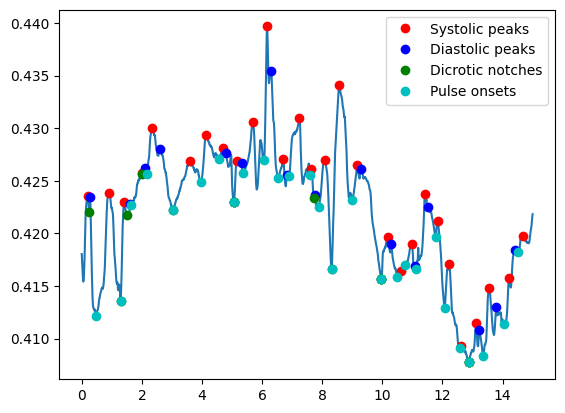

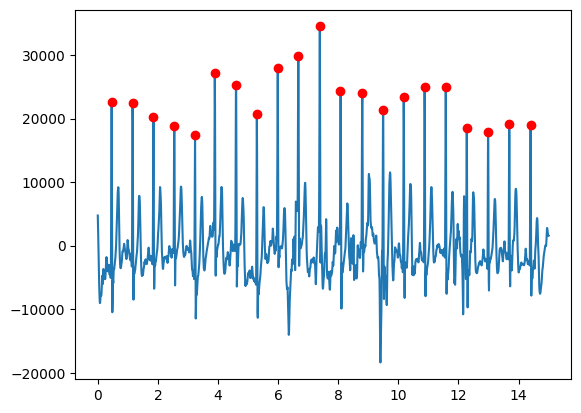

In [4]:
import sqis.calculation.fiducials as fid

wrist_ir_sys, wrist_ir_props, wrist_ir_dst, wrist_ir_dcr, wrist_ir_on = fid.fiducials(signal=wrist_ir_window, fs=fs, prominence=0.0001, height=0.4, pulse_fraction_percentage=0.3)
fid.plot_fiducials(wrist_ir_window, wrist_ir_sys, wrist_ir_dst, wrist_ir_dcr, wrist_ir_on, wrist_ir_time, legend=True)
ecg_peaks, _ = fid.systolic_peaks(ecg_window, fs, prominence=0.2, height=10000)

plt.figure()
plt.plot(ecg_time, ecg_window)
plt.plot(ecg_time[ecg_peaks], ecg_window[ecg_peaks], 'ro')
plt.show()


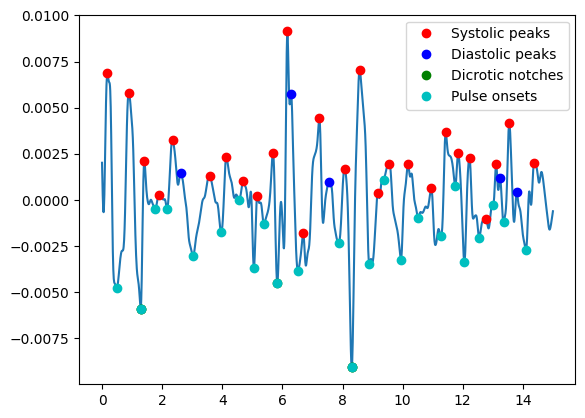

In [6]:
# Now let's try filtering it first
from scipy import signal

nyq = 0.5*fs
lowcut = 0.5
highcut = 8
order = 3

low = lowcut / nyq
high = highcut / nyq

b, a = signal.butter(order, [low, high], btype='band')
filtered_signal = signal.filtfilt(b, a, wrist_ir_window)

filter_sys, filter_props, filter_diastolic, filter_notches, filter_onsets = fid.fiducials(signal=filtered_signal, fs=fs, prominence=0.0002, height=0.1, pulse_fraction_percentage=0.3)
fid.plot_fiducials(filtered_signal, filter_sys, filter_diastolic, filter_notches, filter_onsets, time=wrist_ir_time, legend=True)


# **Test on ideal PPG**

In [ ]:
from scipy.io import loadmat
import sqis.utils.window_f as w
import numpy as np
import sqis.calculation.fiducials as fid

file = loadmat('../data/raw/Sample_PPG_MAT_125Hz.mat', struct_as_record = False, squeeze_me = True)

fs = file['Fs']
data = file['Data']

n = len(data)
delta_t = 1/fs
time = np.linspace(0, (n-1)*delta_t, n)

ppg_window, ppg_time = w.signal_window(data, 0, 8, fs)
time_in_seconds = len(ppg_time)/fs

In [ ]:
ppg_systole, ppg_diastole, ppg_notch, ppg_onset = fid.fiducials(ppg_window, fs, prominence=0.000001, height=1, pulse_fraction_percentage=0.2)

fid.plot_fiducials(ppg_window, ppg_systole, ppg_diastole, ppg_notch, ppg_onset, ppg_time, legend=True)

# **Calculating SQIs**

In [4]:
#Beat count plausibility
ecg_beats = len(ecg_peaks)
ecg_avg = (ecg_beats/time_seconds)*60

beat_count = len(filter_sys)
hr_avg = (beat_count/time_seconds)*60

print(hr_avg, ecg_avg)

104.0 84.0


In [10]:
#Confidence scoring for beat detection

median_prominence = np.median(filter_props["prominences"])
std_prominence = np.std(filter_props["prominences"])
mean_prominence = np.mean(filter_props["prominences"])

cv_prominence = std_prominence/mean_prominence
print(cv_prominence)

0.7458531713970441
